### Homework 3: covariate shift and deep ensembles
CS-229 Spring 2023

In [ ]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


class MyClassifier(t.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50, n_classes=2):
        super().__init__()
        self.fc1 = t.nn.Linear(input_dim, hidden_dim)
        self.fc2 = t.nn.Linear(hidden_dim, n_classes)
        self.relu = t.nn.ReLU()
        self.logsoftmax = t.nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.logsoftmax(out)
        return out

                              
class MyEnsemble(t.nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = t.nn.ModuleList(models)

    def forward(self, x):
        out = t.stack([model(x) for model in self.models])
        out = t.mean(out, dim=0)
        return out


# Load data and construct train dataloaders
x_train, y_train, x_val, y_val, x_test, y_test = t.load('hw3_data.pt')
y_train = y_train.long()
y_test = y_test.long()
y_val = y_val.long()
print('dataset sizes: ', x_train.shape, x_val.shape, x_test.shape)

batch_size = 100
train_ds = t.utils.data.TensorDataset(x_train, y_train)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Create and train models
n_models = 10
models = []
loss_fn = t.nn.NLLLoss()
n_epochs = 10
for i in range(n_models):
    model = MyClassifier(input_dim=x_train.shape[1])
    optimizer = t.optim.Adam(model.parameters())

    for epoch in range(n_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    models.append(model)

model_ens = MyEnsemble(models)

dataset sizes:  torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([1000, 2])


### Output the accuracy and expected calibration error, for the model and ensemble

In [ ]:
def accuracy(model, x, y):
    predictions = model(x)
    _, predicted = t.max(predictions.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct / total


def ece(model, x, y, n_bins=10):
    with t.no_grad():
        scores = t.nn.functional.softmax(model(x), dim=1)
        confidences, predictions = t.max(scores, 1)
        accuracies = predictions.eq(y)

        ece = 0
        bin_boundaries = t.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()

            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += t.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece



def vector_of_results(model):
    columns = ['Acc-train', 'Acc-val', 'Acc-test', 
               'ECE-train', 'ECE-val', 'ECE-test']
    results = t.zeros(6)
    results[0] = accuracy(model, x_train, y_train)
    results[1] = accuracy(model, x_val, y_val)
    results[2] = accuracy(model, x_test, y_test)
    results[3] = ece(model, x_train, y_train)
    results[4] = ece(model, x_val, y_val)
    results[5] = ece(model, x_test, y_test)
    return columns, results

with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()  
        columns, results[:,i] = vector_of_results(model)
    results = results.mean(axis=1)
    
    columns, ens_results = vector_of_results(model_ens)


df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.994    0.993     0.821      0.031    0.033     0.094
Ensemble model      0.993    0.993     0.855      0.030    0.032     0.088


### Visualize the results

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


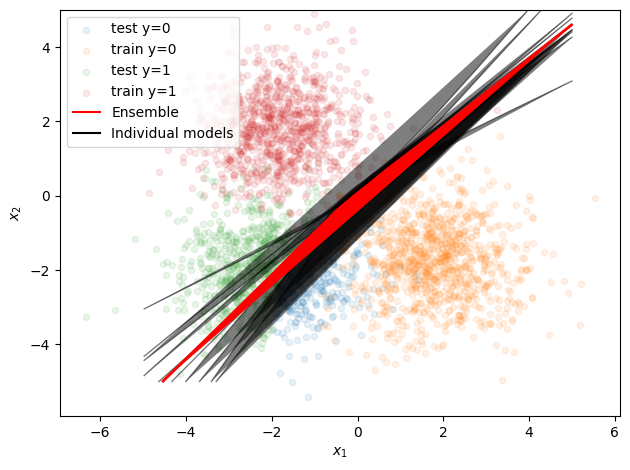

In [ ]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()